<a href="https://colab.research.google.com/github/Hilly12/NLP_CW/blob/main/NLP_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Coursework

## Setup

In [23]:
from IPython.display import clear_output

!pip install simpletransformers
!pip install tensorboardx
!pip install transformers

from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import numpy as np
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
from sklearn.metrics import f1_score

clear_output()

!nvidia-smi

Wed Feb 16 16:25:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |   4083MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

!gdown --folder https://drive.google.com/drive/folders/1XBeRuDSgLziIdTllN4kc3ER2jBgbWI_q
!cp --recursive NLP/* .
!rm -rf NLP

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py
Retrieving folder list
Processing file 16krDXIGeUbpNTIjLKVpBWVHHWIfkwLan dev_semeval_parids-labels.csv
Processing file 1KLEzJBaN7JcpSUrqJwMIV38sU0E3v2RV dontpatronizeme_categories.tsv
Processing file 1X5vMS2MjqT5pDPms87LZqoPmgeX-Hwg2 dontpatronizeme_pcl.tsv
Processing file 1U2cNPyLph0POZTPHcP55iEAIIvCVynMF train_semeval_parids-labels.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=16krDXIGeUbpNTIjLKVpBWVHHWIfkwLan
To: /content/NLP/dev_semeval_parids-labels.csv
100% 61.2k/61.2k [00:00<00:00, 67.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KLEzJBaN7JcpSUrqJwMIV38sU0E3v2RV
To: /content/NLP/dontpatronizeme_categories.tsv
100% 1.34M/1.34M [00:00<00:00, 135MB/s]
Downloading...
From: https://drive.google.com/uc?id=1X5vMS2MjqT5pDPms87LZqoPmgeX-Hwg2
To: /con

In [25]:
from dont_patronize_me import DontPatronizeMe
 
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()

## Data Loading

In [103]:
train_ids = pd.read_csv('train_semeval_parids-labels.csv')
test_ids = pd.read_csv('dev_semeval_parids-labels.csv')
train_ids.par_id = train_ids.par_id.astype(str)
test_ids.par_id = test_ids.par_id.astype(str)

def ids_to_df(ids):
    rows = [] # will contain par_id, label and text
    for idx in range(len(ids)):
        parid = ids.par_id[idx]

        # select row from original dataset to retrieve `text` and binary label
        row = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid]
        text = row.text.values[0]
        label = row.label.values[0]
        keyword = row.keyword.values[0]
        country = row.country.values[0]
        orig_label = int(row.orig_label.values[0])

        rows.append({
            'par_id': parid,
            'text': text,
            'label': label,
            'orig_label': orig_label,
            'kwd': keyword,
            'country': country
        })

    return pd.DataFrame(rows)

In [104]:
train_df1 = ids_to_df(train_ids)
train_df1.head()

,par_id,text,label,orig_label,kwd,country
0,4341,"The scheme saw an estimated 150,000 children f...",1,4,poor-families,gb
1,4136,Durban 's homeless communities reconciliation ...,1,2,homeless,za
2,10352,The next immediate problem that cropped up was...,1,4,poor-families,lk
3,8279,Far more important than the implications for t...,1,2,vulnerable,nz
4,1164,To strengthen child-sensitive social protectio...,1,4,poor-families,gh


In [105]:
test_df1 = ids_to_df(test_ids)
test_df1.head()

,par_id,text,label,orig_label,kwd,country
0,4046,We also know that they can benefit by receivin...,1,3,hopeless,us
1,1279,Pope Francis washed and kissed the feet of Mus...,1,4,refugee,ng
2,8330,Many refugees do n't want to be resettled anyw...,1,2,refugee,ng
3,4063,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4,in-need,ie
4,4089,"""In a 90-degree view of his constituency , one...",1,3,homeless,pk


## Analysis

In [113]:
train_df1["kwd"].unique()

array(['poor-families', 'homeless', 'vulnerable', 'hopeless', 'in-need',
       'disabled', 'women', 'refugee', 'immigrant', 'migrant'],
      dtype=object)

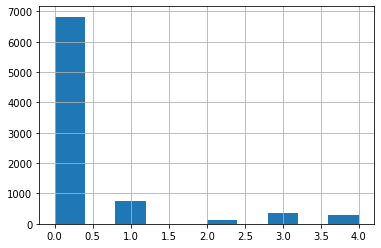

In [107]:
train_df1["orig_label"].hist()

In [127]:
# for kwd in train_df1["kwd"].unique():
#     tp = train_df1[train_df1["kwd"] == kwd]["label"].sum()
#     print(kwd, tp)

## RoBerta

In [30]:
# downsample negative instances
pcldf = train_df1[train_df1.label == 1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf, train_df1[train_df1.label == 0][:npos*2]])
training_set1

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...",1
1,4136,Durban 's homeless communities reconciliation ...,1
2,10352,The next immediate problem that cropped up was...,1
3,8279,Far more important than the implications for t...,1
4,1164,To strengthen child-sensitive social protectio...,1
...,...,...,...
2377,1775,Last but not the least element of culpability ...,0
2378,1776,"Then , taking the art of counter-intuitive non...",0
2379,1777,Kagunga village was reported to lack necessary...,0
2380,1778,"""After her parents high-profile divorce after ...",0


In [34]:
task1_model_args = ClassificationArgs(num_train_epochs=5, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)

task1_model = ClassificationModel("roberta", 
                                  'roberta-base',
                                  args = task1_model_args, 
                                  num_labels=2,
                                  use_cuda=torch.cuda.is_available())
# train model
task1_model.train_model(training_set1[['text', 'label']])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/2382 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/298 [00:00<?, ?it/s]

(1490, 0.5891476008115999)

In [32]:
# Test predictions
# preds_task1, _ = task1_model.predict(test_df1.text.tolist())
# np.mean(preds_task1 == test_df1["label"])

preds_task1, _ = task1_model.predict(train_df1.text.tolist())

f1_score(preds_task1, train_df1["label"])

  0%|          | 0/8375 [00:00<?, ?it/s]

  0%|          | 0/1047 [00:00<?, ?it/s]

0.5124642419288924

## Transformer
